# <center>Option Pricing Models</center>
### Kirill Zakharov
2022

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from functools import partial
from scipy.optimize import minimize, fsolve, newton
import tqdm

%matplotlib inline

plt.style.use('ggplot')
sns.set_palette('mako')
sns.set_style('darkgrid')

In [8]:
class StochasticProcesses:
    def __init__(self, option_type='call'):
        self.option_type = option_type
        
    def geometric_BM(self, T, s0, mu, sigma, n):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.log(s0)
        dt = T/float(n)
        
        for t in range(n):
            x[t+1] = x[t] + (mu - (sigma**2)/2) * dt + sigma * np.sqrt(dt) * stats.norm.rvs(loc=0, scale=1)
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return time, s
    
    def poisson_process(self, T, s0, xiP, n, type_p='ordinary'):
        time = np.zeros(n + 1)
        dt = T/float(n)
        poisson_distr = np.random.poisson(xiP * dt, n + 1)
        
        if type_p == 'ordinary':
            x = np.zeros(n + 1)
            x[0] = s0
            
            for t in range(n):
                x[t+1] = x[t] + poisson_distr[t]
                time[t+1] = time[t] + dt
                
            return time, x
            
        elif type_p == 'compensated':     
            xc = np.zeros(n + 1)
            xc[0] = s0
            
            for t in range(n):
                xc[t+1] = xc[t] + poisson_distr[t] - xiP * dt
                time[t+1] = time[t] + dt
            
            return time, xc
        else:
            print('Wrong type process, available: ordinary and compensated')
            
    def merton_process(self, T, s0, xiP, muj, sigmaj, r, sigma, n):
        time = np.zeros(n + 1)
        dt = T/float(n)
        
        z = np.random.normal(0.0, 1.0, n + 1)
        zj = np.random.normal(muj, sigmaj, n + 1)
        poisson_distr = np.random.poisson(xiP * dt, n + 1)
        
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        
        s[0] = s0
        x[0] = np.log(s0)
        
        EeJ = np.exp(muj + 0.5 * sigmaj**2)

        for t in range(n):
            x[t+1] = x[t] + (r - xiP * (EeJ - 1) - 0.5 * sigma**2) * dt +\
                sigma * np.sqrt(dt) * z[t] + zj[t] * poisson_distr[t]
            
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return time, s
    
    
       
        
    
    def plot_path(self, time, s, label='Process path', title='Process Visualization'):
        plt.subplots(figsize=(10, 5), dpi=100)
        plt.plot(time, s, label=label)
        
        plt.title(title, fontsize=16)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Values', fontsize=14)
        plt.legend()
        plt.show()

In [9]:
process = StochasticProcesses()

In [10]:
T = 10
s0 = 1
r = 0.05
sigma = 0.15
n = 1000

## Geometric Brownian Motion

In [11]:
gbm = process.geometric_BM(T, s0, r, sigma, n)

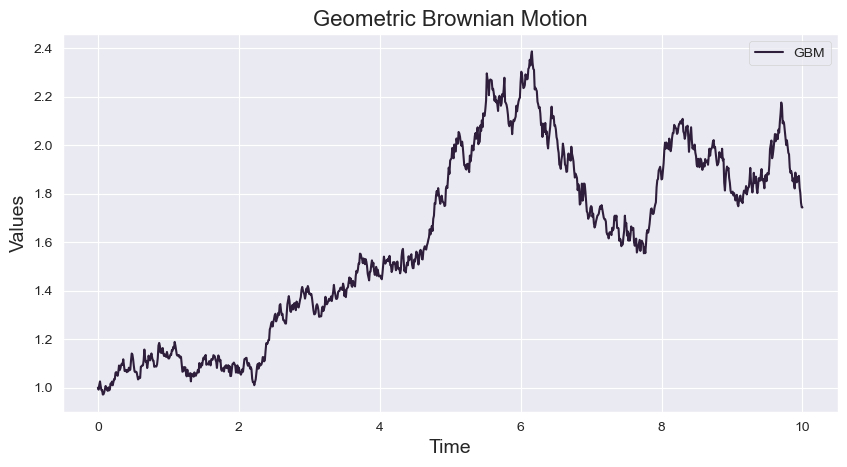

In [12]:
process.plot_path(gbm[0], gbm[1], 'GBM', 'Geometric Brownian Motion')

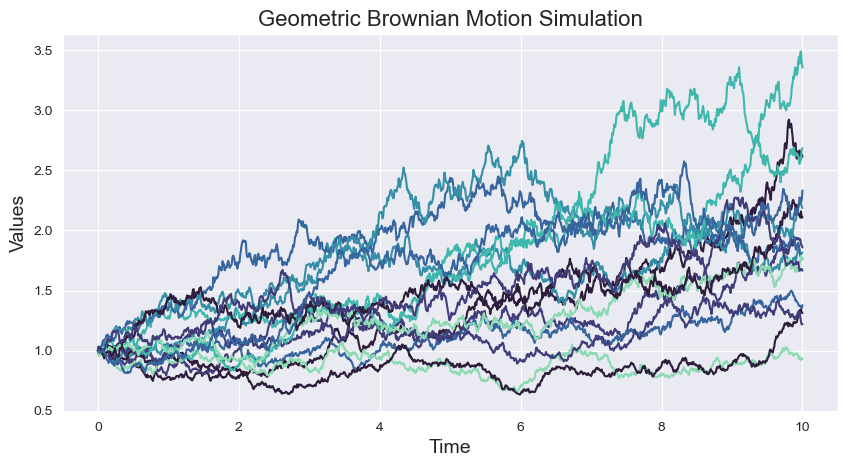

In [13]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(15):
    
    gbm = process.geometric_BM(T, s0, r, sigma, n)

    plt.plot(gbm[0], gbm[1])
        
    plt.title('Geometric Brownian Motion Simulation', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)

## Poisson Process

In [14]:
xiP = 1
T = 50
s0 = 1
n = 50

In [15]:
poisson = process.poisson_process(T, s0, xiP, n, 'ordinary')

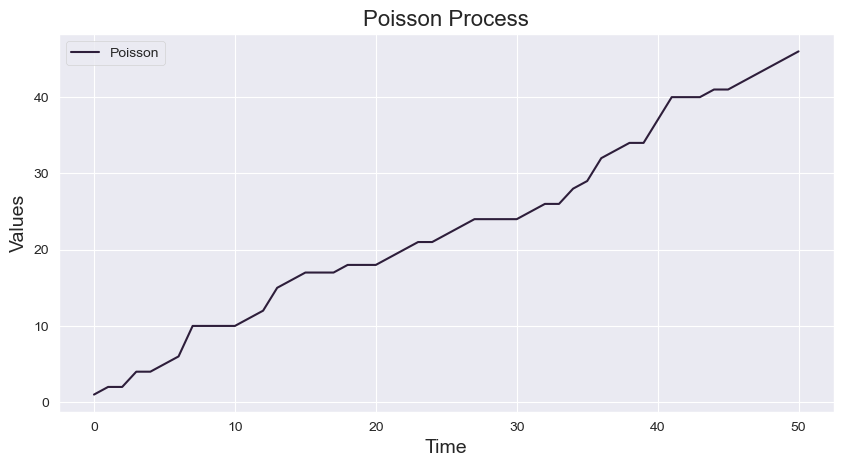

In [16]:
process.plot_path(poisson[0], poisson[1], 'Poisson', 'Poisson Process')

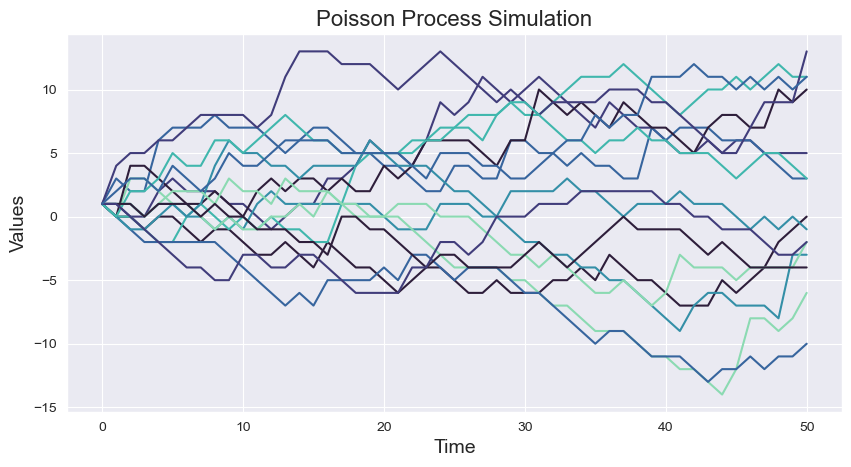

In [17]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(15):
    
    gbm = process.poisson_process(T, s0, xiP, n, 'compensated')

    plt.plot(gbm[0], gbm[1])
        
    plt.title('Poisson Process Simulation', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)

## Merton Process

In [18]:
T = 10
s0 = 1
r = 0.05
sigma = 0.15
n = 1000
xiP = 1
muj = 0
sigmaj = 0.2

In [19]:
merton_process = process.merton_process(T, s0, xiP, muj, sigmaj, r, sigma, n)

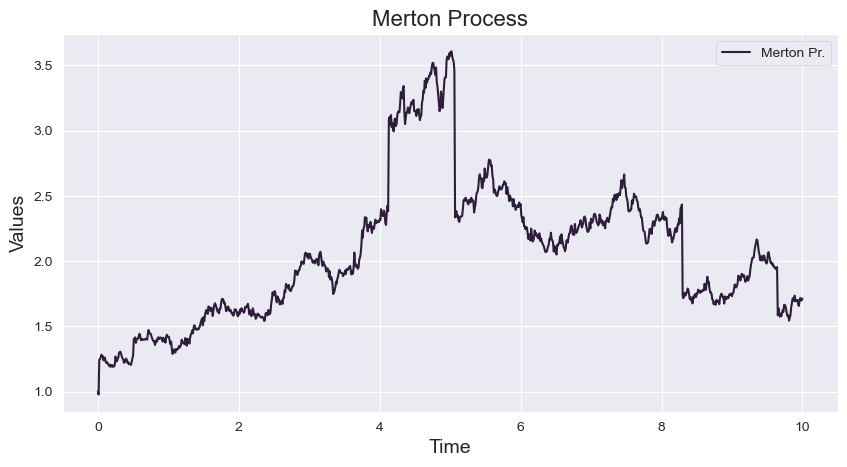

In [20]:
process.plot_path(merton_process[0], merton_process[1], 'Merton Pr.', 'Merton Process')

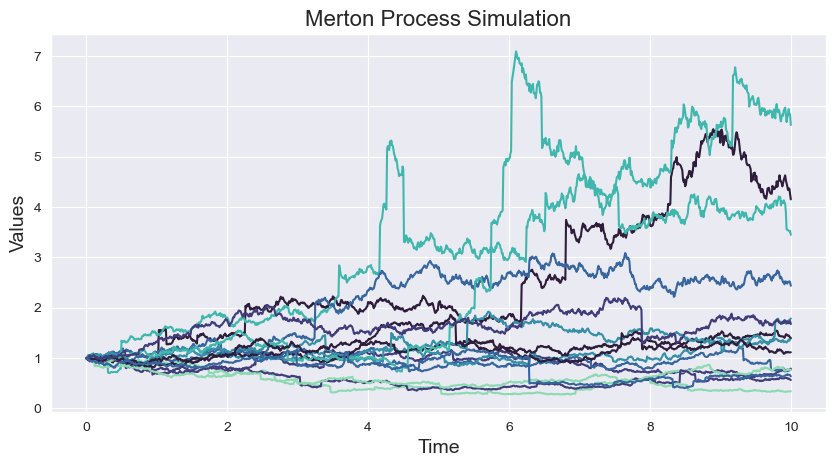

In [21]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(15):
    
    gbm = process.merton_process(T, s0, xiP, muj, sigmaj, r, sigma, n)

    plt.plot(gbm[0], gbm[1])
        
    plt.title('Merton Process Simulation', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)

In [22]:
def GeneratePathsCorrelatedBM(NoOfSteps, T, rho):    
    Z1 = np.random.normal(0.0,1.0, NoOfSteps)
    Z2 = np.random.normal(0.0,1.0, NoOfSteps)
    W1 = np.zeros(NoOfSteps+1)
    W2 = np.zeros(NoOfSteps+1)    
    
    dt = T / float(NoOfSteps)
    time = np.zeros([NoOfSteps+1])
    
    for i in range(0,NoOfSteps):
        Z2[i]= rho * Z1[i] + np.sqrt(1.0 - rho**2) * Z2[i]
        
        W1[i+1] = W1[i] + np.power(dt, 0.5)*Z1[i]
        W2[i+1] = W2[i] + np.power(dt, 0.5)*Z2[i]
        
        time[i+1] = time[i] +dt
        
    return time, W1, W2

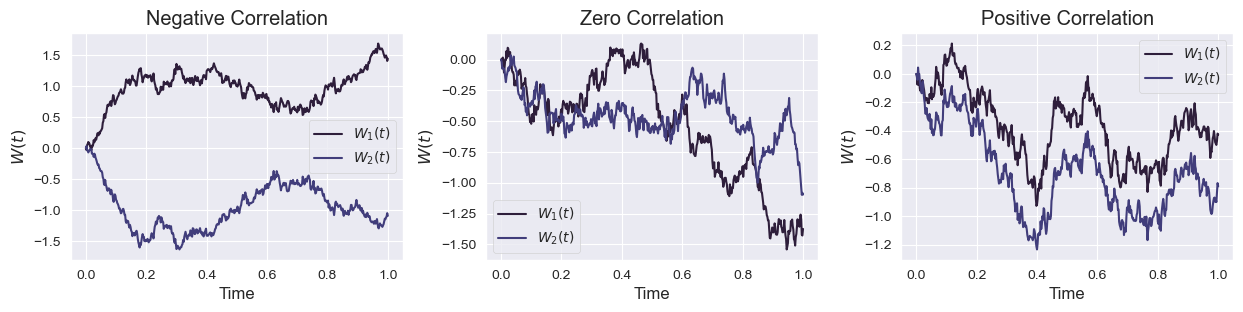

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3), dpi=100)

steps = 500
T = 1.0

cbm = GeneratePathsCorrelatedBM(steps, T, -0.9)
cbm1 = GeneratePathsCorrelatedBM(steps, T, 0)
cbm2 = GeneratePathsCorrelatedBM(steps, T, 0.85)


ax1.plot(cbm[0], np.transpose(cbm[1]), label='$W_1(t)$')
ax1.plot(cbm[0], np.transpose(cbm[2]), label='$W_2(t)$')
ax1.set_title('Negative Correlation')
ax1.set_xlabel('Time')
ax1.set_ylabel('$W(t)$')

ax2.plot(cbm1[0], np.transpose(cbm1[1]), label='$W_1(t)$')
ax2.plot(cbm1[0], np.transpose(cbm1[2]), label='$W_2(t)$')
ax2.set_title('Zero Correlation')
ax2.set_xlabel('Time')
ax2.set_ylabel('$W(t)$')

ax3.plot(cbm2[0], np.transpose(cbm2[1]), label='$W_1(t)$')
ax3.plot(cbm2[0], np.transpose(cbm2[2]), label='$W_2(t)$')
ax3.set_title('Positive Correlation')
ax3.set_xlabel('Time')
ax3.set_ylabel('$W(t)$')

ax1.legend()
ax2.legend()
ax3.legend()

plt.subplots_adjust(wspace = 0.25)
# fig.suptitle('Correlated Brownian Motions', fontsize=16)

plt.show()

## Option Pricing Black-Scholes Model

In [24]:
def black_scholes(s, r, sigma, strike, option_type='call', maturity=10, t=1):
        if option_type == 'call':
            d1 = (np.log(s/strike) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
            d2 = d1 - sigma * np.sqrt(maturity - t)
            
            c = s * stats.norm.cdf(d1, loc=0, scale=1) - strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(d2, loc=0, scale=1)
        
        elif option_type == 'put':       
            d1 = (np.log(s/strike) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
            d2 = d1 - sigma * np.sqrt(maturity - t)
            
            c = strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(-d2, loc=0, scale=1) - s * stats.norm.cdf(-d1, loc=0, scale=1)
            
        else:
            print('Incorrect type, available: call and put')
        
        return c

In [25]:
T = 10
s0 = 100
r = 0.05
K = [75, 80, 90, 110, 130, 135, 140, 150, 170, 200]
tau = T
n = 50
sigma = 0.2
bs_options = []

bs_options = []
for strike in K:
    bs_options.append(black_scholes(s0, r, sigma, strike, option_type='call', maturity=T, t=T-tau))

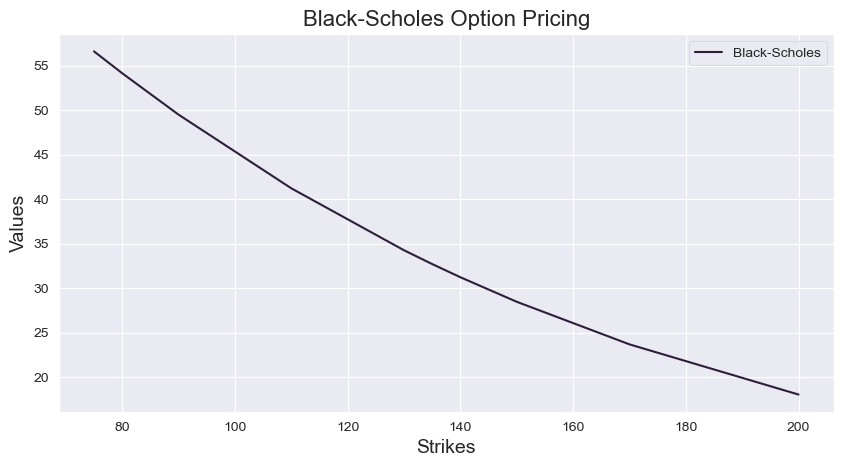

In [26]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(K, bs_options, label='Black-Scholes')
        
plt.title('Black-Scholes Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

## Option Pricing COS Method

In [27]:
def CallPutOptionPriceCOS(cf, CP, s0, r, tau, K, N, L):
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    K = np.array(K).reshape([len(K),1])
    
    i = complex(0.0,1.0) 
    x0 = np.log(s0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  
  
    H_k = Hk_Coefficients(CP,a,b,k)
       
    mat = np.exp(i * np.outer((x0 - a) , u))

    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
         
    return value

In [28]:
def Hk_Coefficients(CP, a, b, k):
    if str(CP).lower() == "c" or str(CP).lower()=="1":                  
        c = 0.0
        d = b
        coef = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k = 2.0 / (b - a) * (Chi_k - Psi_k)  
        
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        c = a
        d = 0.0
        coef = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k  

In [29]:
def Chi_Psi(a, b, c, d, k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [30]:
T = 10
CP = 'c'
s0 = 100
r = 0.05
K = [75, 80, 90, 110, 130, 135, 140, 150, 170, 200]
N = 2**8
L = 8
tau = T
n = 50
sigma = 0.2
bs_options = []

cf = lambda u: np.exp((r - 0.5 * sigma**2)* 1j * u * tau - 0.5 * sigma**2 * u**2 * tau)

option_price_cos = CallPutOptionPriceCOS(cf, CP, s0, r, tau, K, N, L)

In [31]:
bs_options = []
for strike in K:
    bs_options.append(black_scholes(s0, r, sigma, strike, option_type='call', maturity=10, t=T-tau))

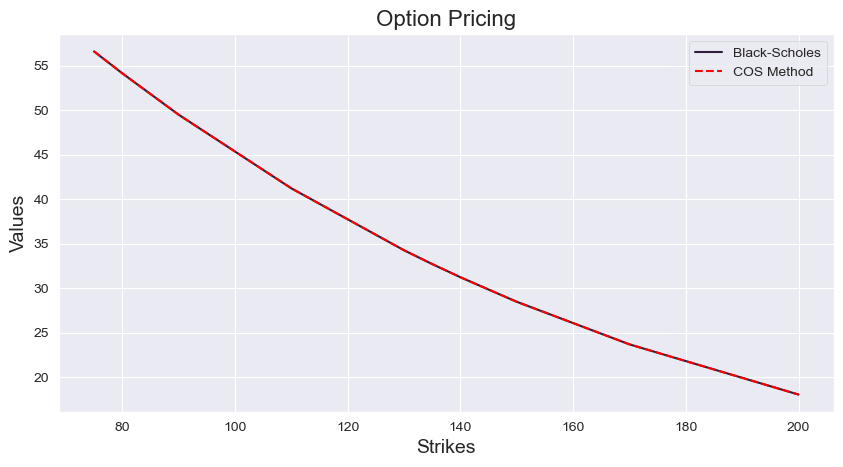

In [32]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(K, bs_options, label='Black-Scholes')
plt.plot(K, option_price_cos.T[0], '--', color='red', label='COS Method')
        
plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

## Option Pricing by Heston Model

In [33]:
def ChFHestonModel(r, tau, kappa, gamma, vbar, v0, rho):
    i = complex(0.0, 1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u, 2)+(u**2 + i*u) * gamma**2)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u + D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma * np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
      
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

In [34]:
def EUOptionPriceFromMCPathsGeneralized(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    result = np.zeros([len(K),1])
    if CP == 'c' or CP == 1:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(S-k,0.0))
    elif CP == 'p' or CP == -1:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(k-S,0.0))
    return result.T[0]

In [35]:
def GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
#     X[:,0]=S_0
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0 - rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma * np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i])
        V[:,i+1] = np.maximum(V[:,i+1],0.0)
        
        X[:,i+1] = X[:,i] + (r - 0.5*V[:,i])*dt + np.sqrt(V[:,i])*(W2[:,i+1]-W2[:,i])
#         X[:, i+1] = X[:, i] + (r * X[:, i]) * dt + np.sqrt(V[:, i]) * X[:, i] *(W2[:,i+1]-W2[:,i])
        time[i+1] = time[i] +dt
        
    #Compute exponent
    S = np.exp(X)
#     S = X
    paths = {"time":time,"S":S}
    return paths

In [36]:
def GeneratePathsHestonMilstein(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    
    V[:,0]=v0
    X[:,0]=S_0
    
    time = np.zeros([NoOfSteps+1])   
    dt = T / float(NoOfSteps)
    
    for i in range(0,NoOfSteps):
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0 - rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        V[:,i+1] = V[:,i] + kappa * (vbar - V[:,i]) * dt + gamma * np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i]) +\
                                0.25 * gamma * ((W1[:,i+1]-W1[:,i])**2 - dt)
        V[:,i+1] = np.maximum(V[:,i+1],0.0)
        
        X[:, i+1] = X[:, i] + (r * X[:, i]) * dt + np.sqrt(V[:, i]) * X[:, i] *(W2[:,i+1]-W2[:,i]) +\
                                0.5 * V[:, i] * X[:, i] * ((W2[:,i+1]-W2[:,i])**2 - dt)
        time[i+1] = time[i] + dt
        
    S = X
    paths = {"time":time,"S":S}
    return paths

In [37]:
numberPaths = 200
N = 500
T = 10
r = 0.05
s0 = 100
kappa = 4
gamma = 0.9
vbar = 0.04
v0 = 0.04
rho = -0.5

# K1 = np.linspace(50, 100 * 1.5, 30)

In [38]:
hestonEuler = GeneratePathsHestonEuler(numberPaths, N, T, r, s0, kappa, gamma, rho, vbar, v0)

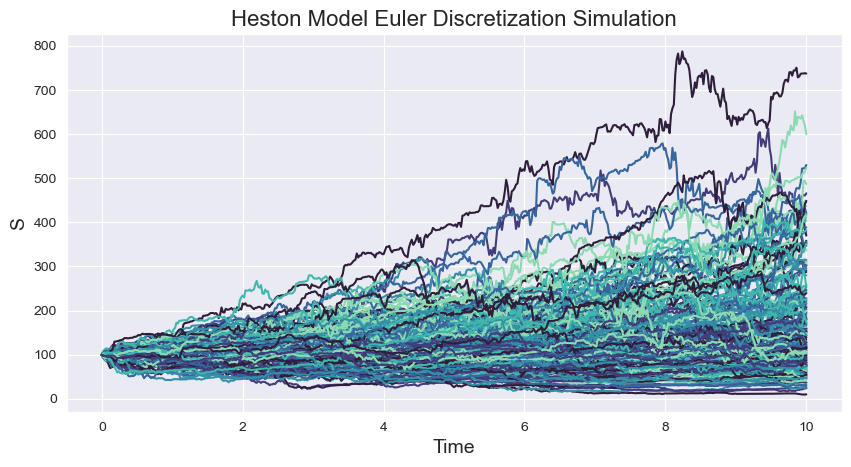

In [39]:
plt.subplots(figsize=(10, 5), dpi=100)

for path in hestonEuler['S']:
    plt.plot(hestonEuler['time'], path)
        
plt.title('Heston Model Euler Discretization Simulation', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.show()

In [40]:
hestonMilstein = GeneratePathsHestonMilstein(numberPaths, N, T, r, s0, kappa, gamma, rho, vbar, v0)

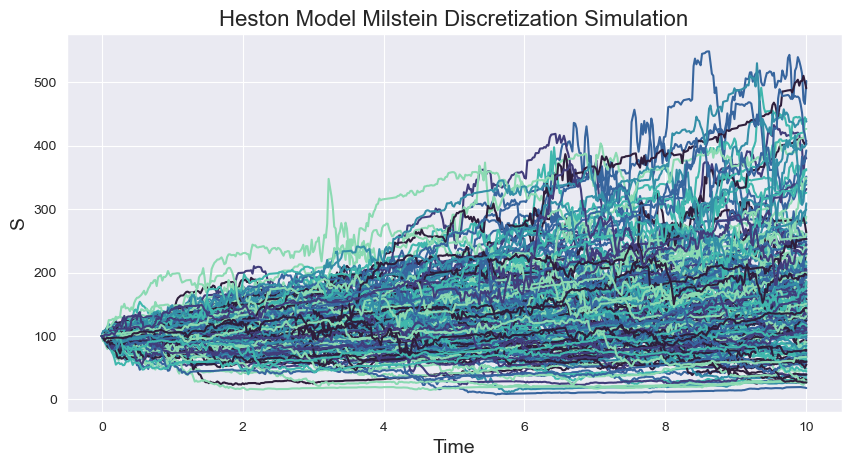

In [41]:
plt.subplots(figsize=(10, 5), dpi=100)

for path in hestonMilstein['S']:
    plt.plot(hestonMilstein['time'], path)
        
plt.title('Heston Model Milstein Discretization Simulation', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.show()

In [42]:
kappa = 4
gamma = 0.9
vbar = 0.04
v0 = 0.04
rho = -0.5
T = 10
K = [75, 80, 90, 110, 130, 135, 140, 150, 170, 200]
tau = 10

cf_heston = ChFHestonModel(r, tau, kappa, gamma, vbar, v0, rho)

option_price_heston = CallPutOptionPriceCOS(cf_heston, CP, s0, r, tau, K, N, L)
option_price_heston_euler = EUOptionPriceFromMCPathsGeneralized('c', hestonEuler['S'][:, -1], K, T, r)
option_price_heston_milstein = EUOptionPriceFromMCPathsGeneralized('c', hestonMilstein['S'][:, -1], K, T, r)

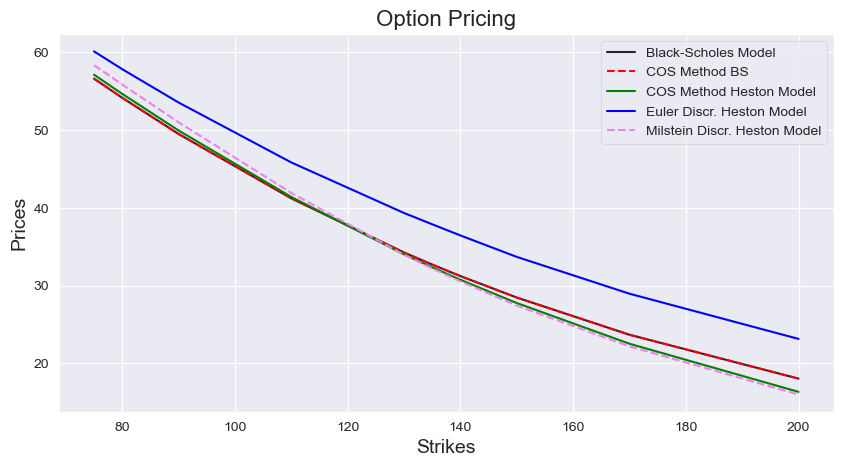

In [43]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(K, bs_options, label='Black-Scholes Model')
plt.plot(K, option_price_cos.T[0], '--', color='red', label='COS Method BS')
plt.plot(K, option_price_heston.T[0], color='green', label='COS Method Heston Model')
plt.plot(K, option_price_heston_euler, color='blue', label='Euler Discr. Heston Model')
plt.plot(K, option_price_heston_milstein, '--', color='violet', label='Milstein Discr. Heston Model')
        
plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend()
plt.show()

In [44]:
def correlation_process(NoOfPaths, NoOfSteps, T, r, v0, s0, rho0, rho1, rho2, kappa, gamma, rho, vbar, kappa_rho, mu_rho, sigma_rho):
    Z1 = np.random.normal(0.0,1.0, [NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0, [NoOfPaths,NoOfSteps])
    Z3 = np.random.normal(0.0, 1.0, [NoOfPaths,NoOfSteps])
    
    W1 = np.zeros([NoOfPaths, NoOfSteps + 1])
    W2 = np.zeros([NoOfPaths, NoOfSteps + 1])
    W3 = np.zeros([NoOfPaths, NoOfSteps + 1])
    
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    rho = np.zeros([NoOfPaths, NoOfSteps+1])
    
    V[:,0] = v0
    X[:,0] = np.log(s0)
    rho[:, 0] = rho0
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        Z2[:, i] = rho1 * Z1[:, i] + np.sqrt(1 - rho1**2) * Z2[:, i]
        Z3[:, i] = rho[:, i] * Z1[:, i] + (rho2 - rho1 * rho[:, i])/np.sqrt(1 - rho1**2) * Z2[:, i] + \
                                        np.sqrt(abs(1 - rho[:, i]**2 - ((rho2 - rho1 * rho[:, i])/np.sqrt(1 - rho1**2))**2)) * Z3[:, i]
        
        
        W1[:, i+1] = W1[:,i] + np.power(dt, 0.5) * Z1[:,i]
        W2[:, i+1] = W2[:,i] + np.power(dt, 0.5) * Z2[:,i]
        W3[:, i+1] = W3[:,i] + np.power(dt, 0.5) * Z3[:,i]
        
        V[:, i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1] - W1[:,i])
        V[:, i+1] = np.maximum(V[:,i+1], 0.0)
        
        rho[:, i+1] = rho[:, i] + kappa_rho * (mu_rho - rho[:, i]) * dt + sigma_rho * (W2[:,i+1] - W2[:,i])
        
        X[:,i+1] = X[:,i] + (r - 0.5 * V[:,i]) * dt + np.sqrt(V[:,i]) * (W3[:,i+1]-W3[:,i])
        time[i+1] = time[i] +dt
        
    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S, 'rho': rho}
    return paths

In [115]:
numberPaths = 50
N = 200
T = 10
r = 0.05
s0 = 100
kappa = 4
gamma = 0.9
vbar = 0.04
v0 = 0.04
rho0 = -0.5
rho1 = 0.1
rho2 = 0.1
kappa_rho = 5
mu_rho = 0.2
sigma_rho = 0.4

In [116]:
corr_process = correlation_process(numberPaths, N, T, r, v0, s0, rho0, rho1, rho2, kappa, gamma, rho, vbar, kappa_rho, mu_rho, sigma_rho)

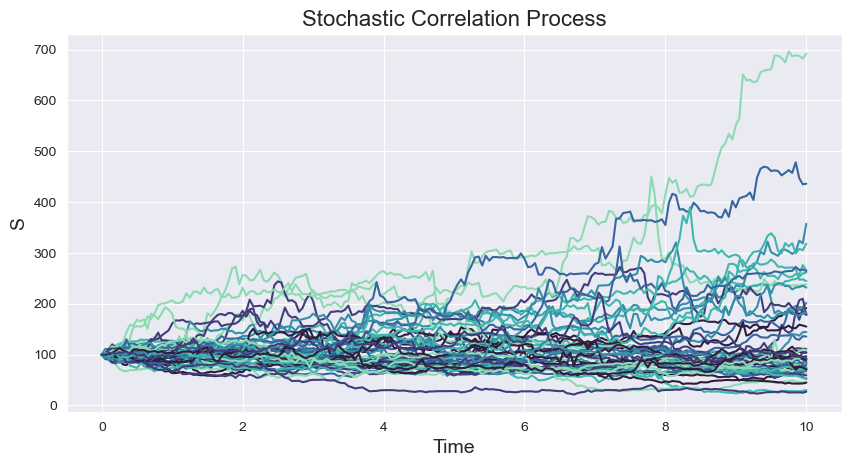

In [117]:
plt.subplots(figsize=(10, 5), dpi=100)

for path in corr_process['S']:
    plt.plot(corr_process['time'], path)
        
plt.title('Stochastic Correlation Process', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.show()

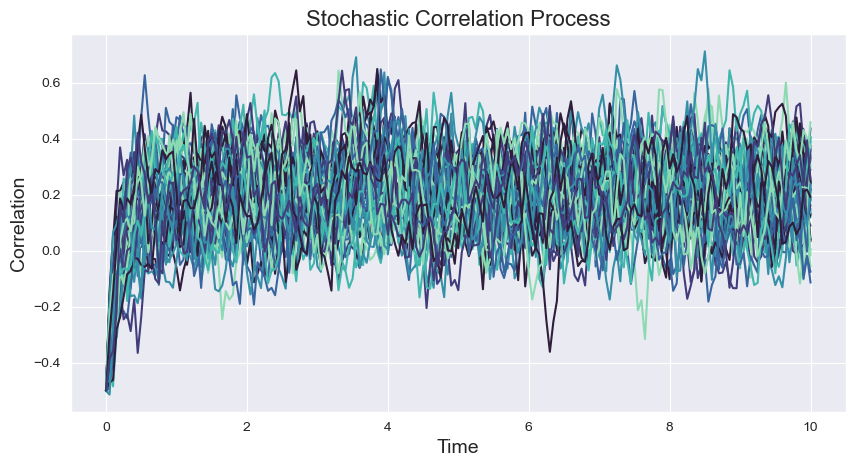

In [118]:
plt.subplots(figsize=(10, 5), dpi=100)

for path in corr_process['rho']:
    plt.plot(corr_process['time'], path)
        
plt.title('Stochastic Correlation Process', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.show()

In [119]:
option_corr_process = EUOptionPriceFromMCPathsGeneralized('c', corr_process['S'][:, -1], K, T, r)

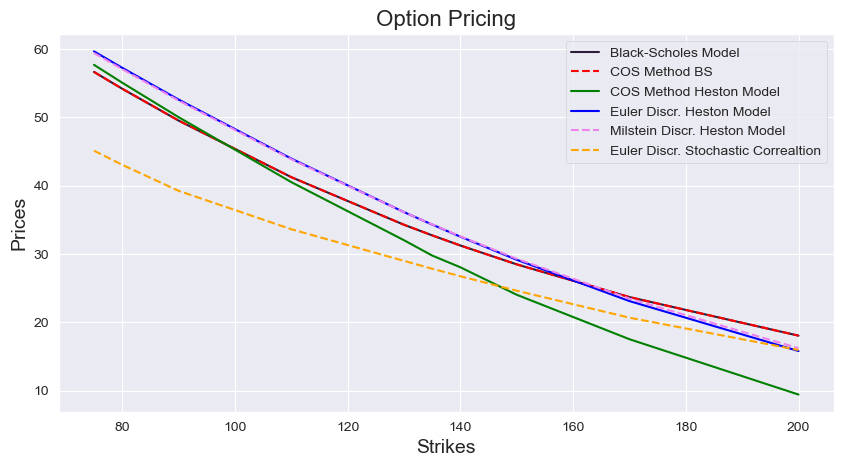

In [120]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(K, bs_options, label='Black-Scholes Model')
plt.plot(K, option_price_cos.T[0], '--', color='red', label='COS Method BS')
plt.plot(K, option_price_heston.T[0], color='green', label='COS Method Heston Model')
plt.plot(K, option_price_heston_euler, color='blue', label='Euler Discr. Heston Model')
plt.plot(K, option_price_heston_milstein, '--', color='violet', label='Milstein Discr. Heston Model')
plt.plot(K, option_corr_process, '--', color='orange', label='Euler Discr. Stochastic Correaltion')

plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend()
plt.show()

## Almost Exact Solution for the Heston Model

In [51]:
def CIR_exact(numberPaths, kappa, gamma, vbar, s, t, v_s):
    delta = 4.0 * kappa * vbar/gamma**2
    
    c = gamma**2/(4.0*kappa) * (1 - np.exp(-kappa * (t-s)))
    
    kappaBar = 4 * kappa * v_s * np.exp(-kappa * (t-s))/(gamma**2 * (1 - np.exp(-kappa * (t-s))))
    
    return  c * np.random.noncentral_chisquare(delta, kappaBar, numberPaths)

def heston_almost_exact_solution(numberPaths, N, s0, v0, T, kappa, gamma, vbar, rho, r):
    X = np.zeros([numberPaths, N + 1])
    S = np.zeros([numberPaths, N + 1])
    V = np.zeros([numberPaths, N + 1])
    time = np.zeros(N + 1)
    
    Zx = np.random.normal(0, 1, [numberPaths, N])
    
    X[:, 0] = np.log(s0)
    V[:, 0] = v0
    
    dt = T/float(N)
    
    for t in range(N):
        
        V[:, t+1] = CIR_exact(numberPaths, kappa, gamma, vbar, 0, dt, V[:, t])
        
        X[:, t+1] = X[:, t] + (r - vbar*kappa*rho/gamma) * dt + ((kappa*rho/gamma - 0.5) * dt - rho/gamma) * V[:, t] +\
                                        rho/gamma * V[:, t+1] + np.sqrt((1-rho**2) * dt * V[:, t]) * Zx[:, t]
        
        time[t+1] = time[t] + dt
    S = np.exp(X)        
        
    return time, S, V

In [52]:
numberPaths = 100
N = 200
T = 10
s0 = 100
v0 = 0.04
kappa = 0.7
gamma = 0.8
vbar = 0.04
rho = -0.8

heston_aes = heston_almost_exact_solution(numberPaths, N, s0, v0, T, kappa, gamma, vbar, rho, r)

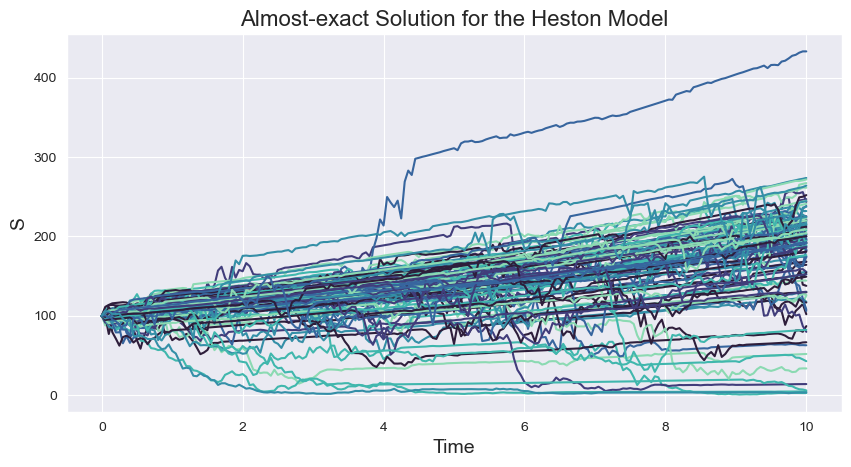

In [53]:
plt.subplots(figsize=(10, 5), dpi=100)

for path in heston_aes[1]:
    plt.plot(heston_aes[0], path)
        
plt.title('Almost-exact Solution for the Heston Model', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.show()

In [54]:
numberPaths = 2000
N = 1000
T = 10
L = 8
tau = T
r = 0.05

s0 = 100
v0 = 0.04
vbar = 0.04

kappa = 1
gamma = 0.8
rho = -0.8
sigma = 0.2

rho0 = -0.8
rho1 = 0.3
rho2 = 0.3
kappa_rho = 0.4
mu_rho = 0.3
sigma_rho = 0.2

corr_process = correlation_process(numberPaths, N, T, r, v0, s0, rho0, rho1, rho2, kappa,
                                   gamma, rho, vbar, kappa_rho, mu_rho, sigma_rho)
heston_aes = heston_almost_exact_solution(numberPaths, N, s0, v0, T, kappa, gamma, vbar, rho, r)
hestonMilstein = GeneratePathsHestonMilstein(numberPaths, N, T, r, s0, kappa, gamma, rho, vbar, v0)
hestonEuler = GeneratePathsHestonEuler(numberPaths, N, T, r, s0, kappa, gamma, rho, vbar, v0)

cf_heston = ChFHestonModel(r, tau, kappa, gamma, vbar, v0, rho)
cf_bs = lambda u: np.exp((r - 0.5 * sigma**2)* 1j * u * tau - 0.5 * sigma**2 * u**2 * tau)

bs_options = []
for strike in K:
    bs_options.append(black_scholes(s0, r, sigma, strike, option_type='call', maturity=T, t=T-tau))
    
option_price_cos_BS = CallPutOptionPriceCOS(cf_bs, CP, s0, r, tau, K, N, L)
option_price_heston = CallPutOptionPriceCOS(cf_heston, CP, s0, r, tau, K, N, L)
option_price_heston_euler = EUOptionPriceFromMCPathsGeneralized('c', hestonEuler['S'][:, -1], K, T, r)
option_price_heston_milstein = EUOptionPriceFromMCPathsGeneralized('c', hestonMilstein['S'][:, -1], K, T, r)
option_heston_aes = EUOptionPriceFromMCPathsGeneralized('c', heston_aes[1][:, -1], K, T, r)
option_corr_process = EUOptionPriceFromMCPathsGeneralized('c', corr_process['S'][:, -1], K, T, r)

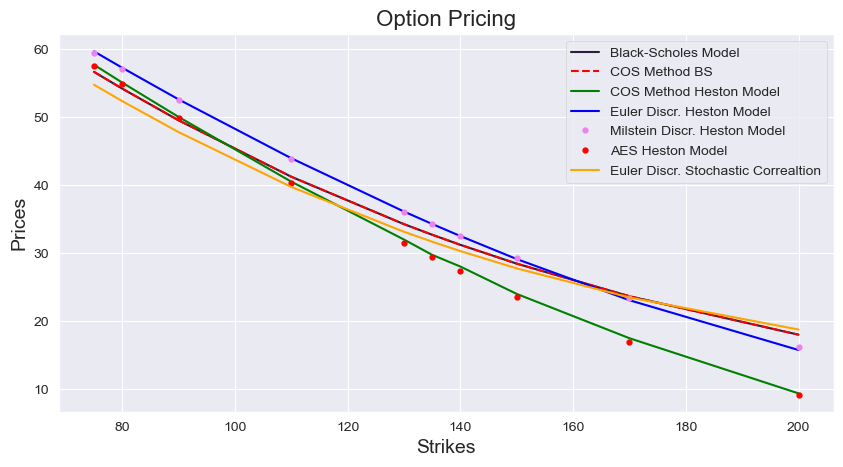

In [55]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(K, bs_options, label='Black-Scholes Model')
plt.plot(K, option_price_cos_BS.T[0], '--', color='red', label='COS Method BS')
plt.plot(K, option_price_heston.T[0], color='green', label='COS Method Heston Model')
plt.plot(K, option_price_heston_euler, color='blue', label='Euler Discr. Heston Model')
plt.plot(K, option_price_heston_milstein,'.', markersize=7, color='violet', label='Milstein Discr. Heston Model')
plt.plot(K, option_heston_aes, '.', markersize=7, color='red', label='AES Heston Model')
plt.plot(K, option_corr_process, color='orange', label='Euler Discr. Stochastic Correaltion')

plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend(loc=1)
plt.show()

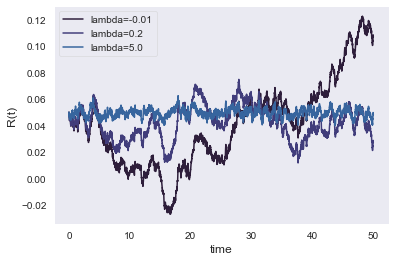

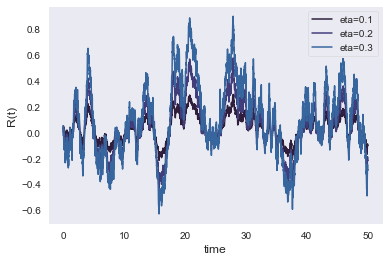

In [347]:
import numpy as np
import matplotlib.pyplot as plt

def GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambd, eta):    
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + \
    eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    R[:,0]=r0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + eta* (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt
        
    # Outputs
    paths = {"time":time,"R":R}
    return paths

def mainCalculation():
    NoOfPaths = 1
    NoOfSteps = 5000
    T         = 50.0
    lambd     = 0.5
    eta       = 0.01
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T) 

    # Effect of mean reversion lambda
    plt.figure(1) 
    legend = []
    lambdVec = [-0.01, 0.2, 5.0]
    for lambdTemp in lambdVec:    
        np.random.seed(2)
        Paths = GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambdTemp, eta)
        legend.append('lambda={0}'.format(lambdTemp))
        timeGrid = Paths["time"]
        R = Paths["R"]
        plt.plot(timeGrid, np.transpose(R))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("R(t)")
    plt.legend(legend)
        
    # Effect of the volatility
    plt.figure(2)    
    legend = []
    etaVec = [0.1, 0.2, 0.3]
    for etaTemp in etaVec:
        np.random.seed(2)
        Paths = GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambd, etaTemp)
        legend.append('eta={0}'.format(etaTemp))
        timeGrid = Paths["time"]
        R = Paths["R"]
        plt.plot(timeGrid, np.transpose(R))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("R(t)")
    plt.legend(legend)
    
mainCalculation()

In [104]:
def ChFBatesModel(r,tau,kappa,gamma,vbar,v0,rho,xiP,muJ,sigmaJ):
    i = complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*\
                               np.exp(-D1(u)*tau)))*(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    AHes= lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*\
        rho*i*u-D1(u)) - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    
    A = lambda u: AHes(u) - xiP * i * u * tau *(np.exp(muJ+0.5*sigmaJ*sigmaJ) - 1.0) + \
            xiP * tau * (np.exp(i*u*muJ - 0.5 * sigmaJ * sigmaJ * u * u) - 1.0)
     
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

In [109]:
cf_bates = ChFBatesModel(r, tau, kappa, gamma, vbar, v0, rho, 1, muj, sigmaj)

batesModel_cos = CallPutOptionPriceCOS(cf_bates, CP, s0, r, tau, K, N, L)

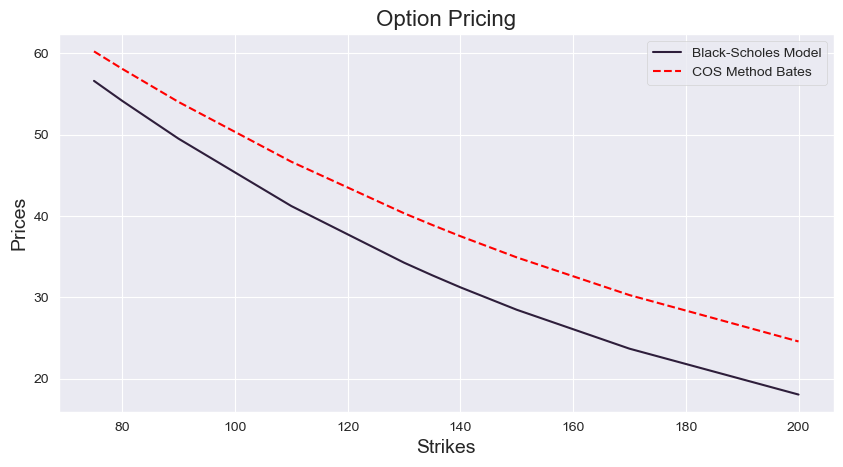

In [110]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(K, bs_options, label='Black-Scholes Model')
plt.plot(K, batesModel_cos.T[0], '--', color='red', label='COS Method Bates')

plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend(loc=1)
plt.show()

In [96]:
# Implied volatility method
def ImpliedVolatility(CP,marketPrice,K,T,S_0,r):
    # To determine initial volatility we interpolate define a grid for sigma
    # and interpolate on the inverse
    sigmaGrid = np.linspace(0,2,200)
    optPriceGrid = BS_Call_Option_Price(CP,S_0,K,sigmaGrid,T,r)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    print("Initial volatility = {0}".format(sigmaInitial))
    
    # Use determined input for the local-search (final tuning)
    func = lambda sigma: np.power(BS_Call_Option_Price(CP,S_0,K,sigma,T,r) - marketPrice, 1.0)
    impliedVol = newton(func, sigmaInitial, tol=1e-10)
    print("Final volatility = {0}".format(impliedVol))
    return impliedVol

In [97]:
# Black-Scholes Call option price
def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == 'c':
        value = stats.norm.cdf(d1) * S_0 - stats.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == 'p':
        value = stats.norm.cdf(-d2) * K * np.exp(-r * tau) - stats.norm.cdf(-d1)*S_0
    return value

In [100]:
ImpliedVolatility('c', 110, 100, 10, 100, 0.05)

Initial volatility = 2.0


<ipython-input-97-1d0c240c98bf>:5: RuntimeWarning: divide by zero encountered in true_divide
  d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))


RuntimeError: Tolerance of 1262.3576587134364 reached. Failed to converge after 3 iterations, value is 1279.7062037038581.

In [291]:
def ImpliedVolatility(CP, S_0, K, sigma, tau, r, niter):
    error = 1e10
    
    optPrice = lambda sigma: black_scholes(s0, r, sigma, strike, 'call', T, 5)
    vega = lambda sigma: dV_dsigma(S_0, K, sigma, tau, r)
    count = 0
    prev_sigma = sigma
    
    while error > 10e-10 and count < niter and (prev_sigma - sigma) < 0.5:
        g = optPrice(sigma) - V_market
        g_prim = vega(sigma)
        
        if g_prim != 0:
            sigma_new = sigma - g / g_prim

            error = abs(g)
            prev_sigma = sigma
            sigma = sigma_new;

    #         print('iteration {0} with error = {1}'.format(n, error))

        else:
            break
            
        count += 1    
    
    return sigma

def dV_dsigma(S_0, K, sigma, tau, r):
    d2   = (np.log(S_0 / float(K)) + (r - 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    value = K * np.exp(-r * tau) * stats.norm.pdf(d2) * np.sqrt(tau)
    
    return value

In [307]:
V_market = 20

imp_vol = ImpliedVolatility('c', s0, K[-1], sigma, tau, r, 1000)
imp_vol

0.26403022934623976

In [293]:
imp_vol_array = []
for k in K:
    imp_vol_array.append(ImpliedVolatility('c', s0, k, sigma, tau, r, 1000))

In [296]:
indx = np.where(np.array(imp_vol_array) > 0)

In [298]:
np.array(imp_vol_array)[indx]

array([0.03466763, 0.26403023, 0.26403023, 0.26403023, 0.26403023])

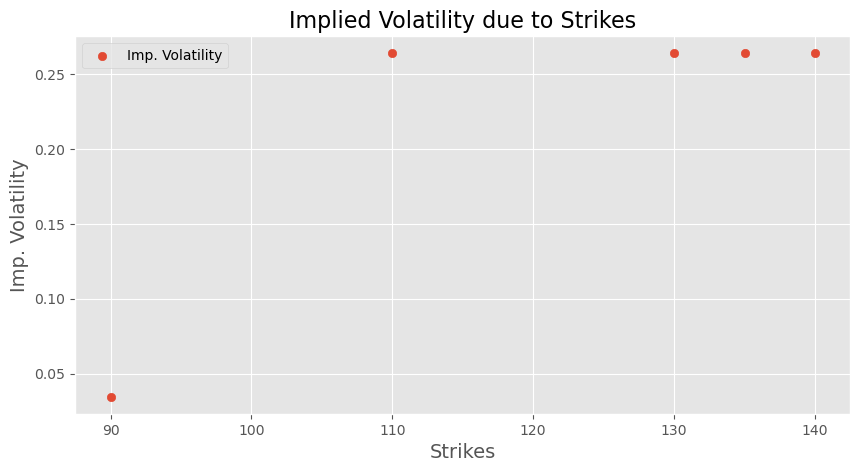

In [303]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.scatter(np.array(K)[indx], np.array(imp_vol_array)[indx], label='Imp. Volatility')
        
plt.title('Implied Volatility due to Strikes', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Imp. Volatility', fontsize=14)
plt.legend()
plt.show()